In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import load_model
import splitfolders
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

### Preprocessing

#### Data Split

In [2]:
path = "TB_Chest_Radiography_Database"
splitfolders.ratio(path, output = "TB Images", ratio = (0.7, 0.15, 0.15), group_prefix = None)

#### Memuat Dataset

In [3]:
img_width = 224
img_height = 224
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r"TB Images\train",
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r"TB Images\val",
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r"TB Images\test",
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)


Found 3863 files belonging to 2 classes.
Found 1178 files belonging to 2 classes.
Found 1180 files belonging to 2 classes.


#### Augmentasi Data

In [4]:
# Definisikan layer augmentasi data tambahan
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomContrast(0.2),       # Tambahkan kontras acak
    layers.RandomBrightness(0.2)     # Tambahkan kecerahan acak
])

# Terapkan augmentasi data pada dataset pelatihan
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

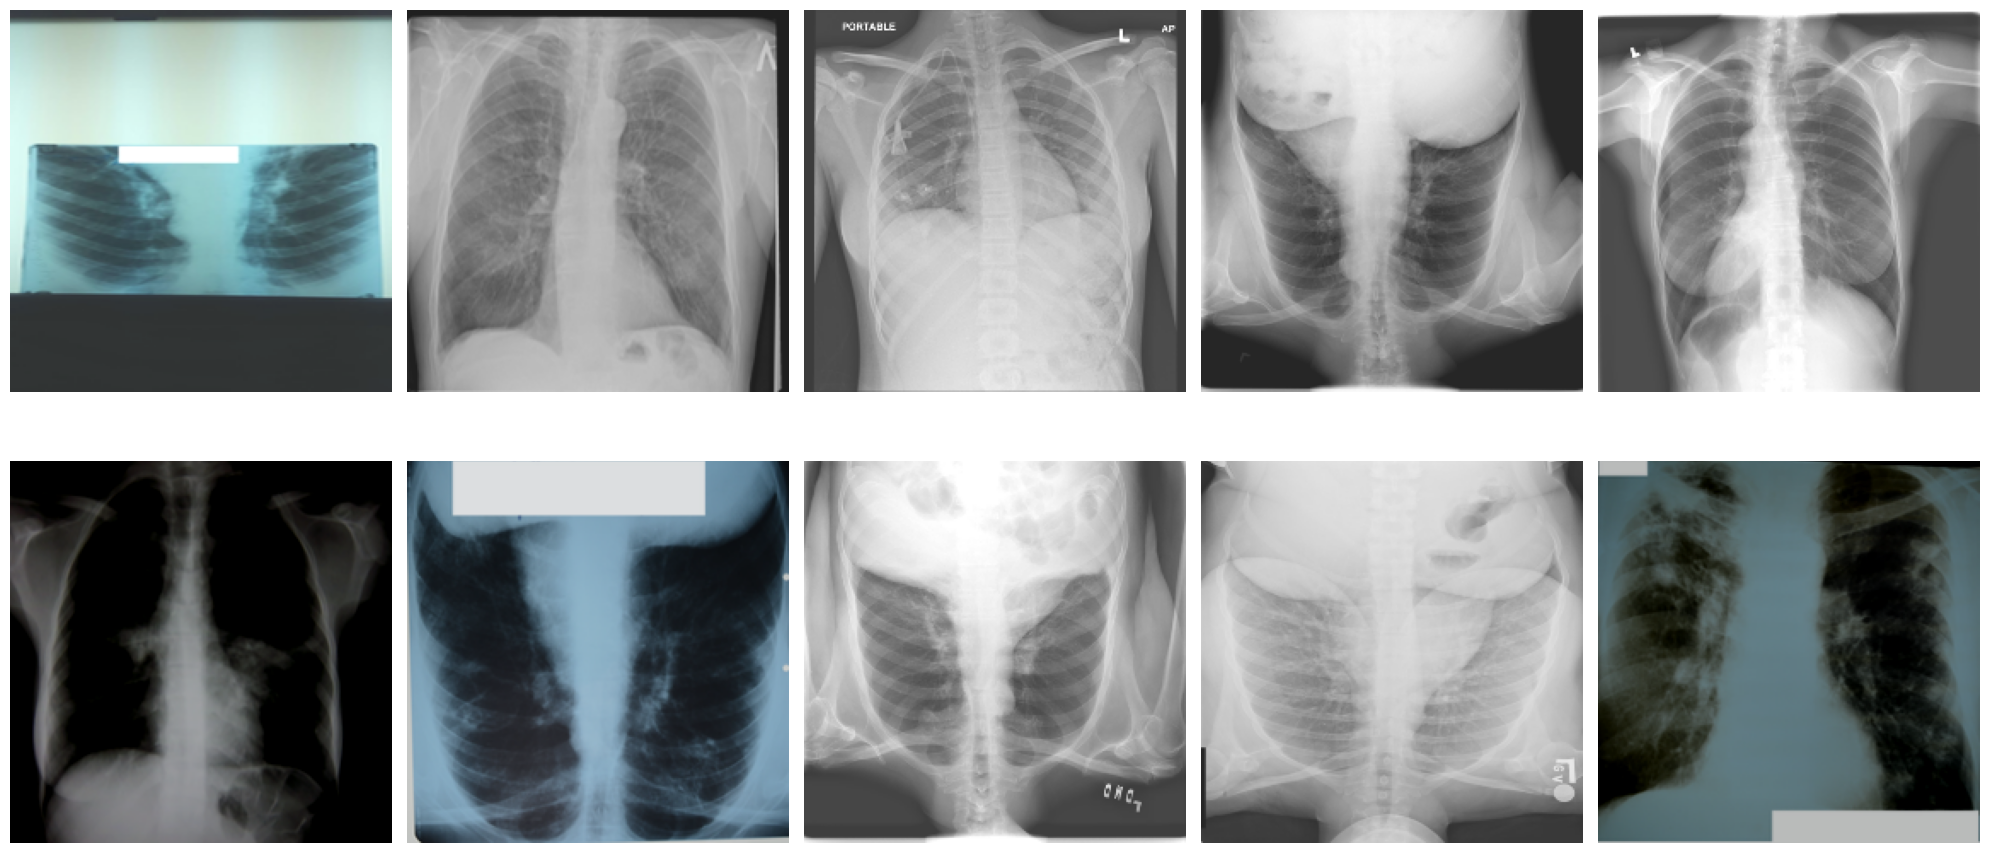

In [5]:
# Fungsi untuk menampilkan gambar
def plot_images(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Ambil satu batch gambar
for images, _ in train_ds.take(1):
    # Terapkan augmentasi data pada batch gambar
    augmented_images = data_augmentation(images)
    # Konversi tensor ke numpy array
    augmented_images_np = augmented_images.numpy().astype("uint8")
    # Tampilkan gambar-gambar yang telah di-augmentasi
    plot_images(augmented_images_np)

#### Preview

In [6]:
class_names = train_ds.class_names
print(class_names)

['Normal', 'Tuberculosis']


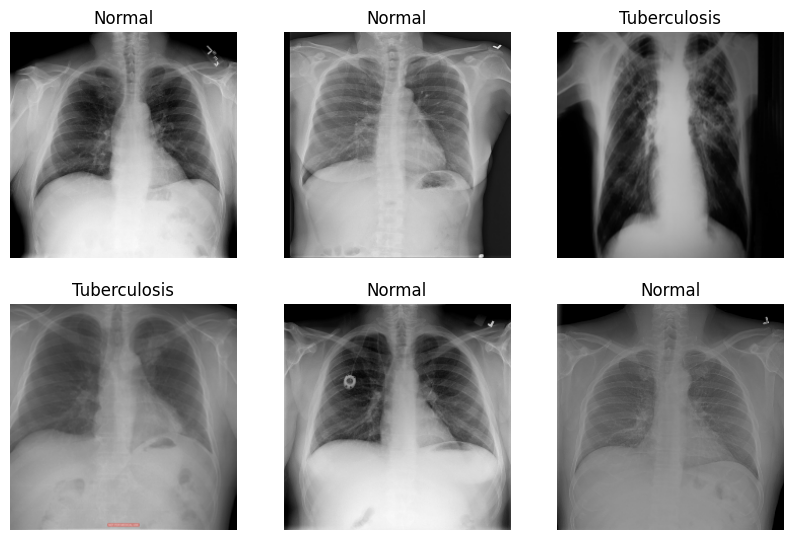

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    # Convert one-hot encoded label to integer
    label_int = np.argmax(labels[i])
    plt.title(class_names[label_int])
    plt.axis("off")

### Build the Model

#### EfficientNetV2B0

In [11]:
# Define model without top layers
pretrained_model = keras.applications.EfficientNetV2B0(include_top=False,
                                             input_shape=(224, 224, 3),
                                             weights='imagenet')

# Freeze the layers of the base model
for layer in pretrained_model.layers:
    layer.trainable = False
    
#Define the Sequential model
model = keras.Sequential([
    pretrained_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Adding L2 regularization
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Adding L2 regularization
    Dense(2, activation='softmax')
])

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               16056576  
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 21992466 (83.89 MB)
Trainable params: 16073154 (61.31 MB)
Non-trainable params: 5919312 (22.58 MB)
_______

In [12]:
# Define a callback to save the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint('EfficientV2B0_BestModel.h5')

# Compile the model with callbacks
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks to the fit method
history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
61/61 [==============================] - 136s 2s/step - loss: 4.8091 - accuracy: 0.9456 - val_loss: 1.9977 - val_accuracy: 0.9873
Epoch 2/10
61/61 [==============================] - 93s 2s/step - loss: 1.3084 - accuracy: 0.9819 - val_loss: 0.9170 - val_accuracy: 0.9932
Epoch 3/10
61/61 [==============================] - 87s 1s/step - loss: 0.7525 - accuracy: 0.9855 - val_loss: 0.5613 - val_accuracy: 0.9941
Epoch 4/10
61/61 [==============================] - 93s 2s/step - loss: 0.5458 - accuracy: 0.9829 - val_loss: 0.4769 - val_accuracy: 0.9958
Epoch 5/10
61/61 [==============================] - 89s 1s/step - loss: 0.4723 - accuracy: 0.9860 - val_loss: 0.3491 - val_accuracy: 0.9958
Epoch 6/10
61/61 [==============================] - 91s 1s/step - loss: 0.3538 - accuracy: 0.9850 - val_loss: 0.3895 - val_accuracy: 0.9830
Epoch 7/10
61/61 [==============================] - 92s 2s/step - loss: 0.3787 - accuracy: 0.9814 - val_loss: 0.3890 - val_accuracy: 0.9915
Epoch 8/10
61/61 [=

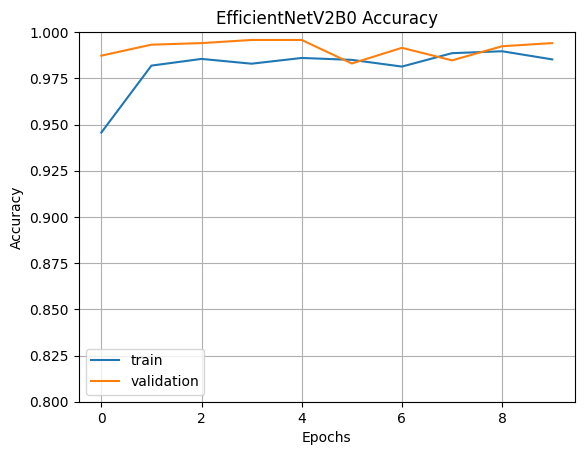

In [13]:
fig4 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.8,ymax=1)
plt.grid()
plt.title('EfficientNetV2B0 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [14]:
loaded_model = load_model('EfficientV2B0_BestModel.h5')

1/1 [==============================] - 3s 3s/step


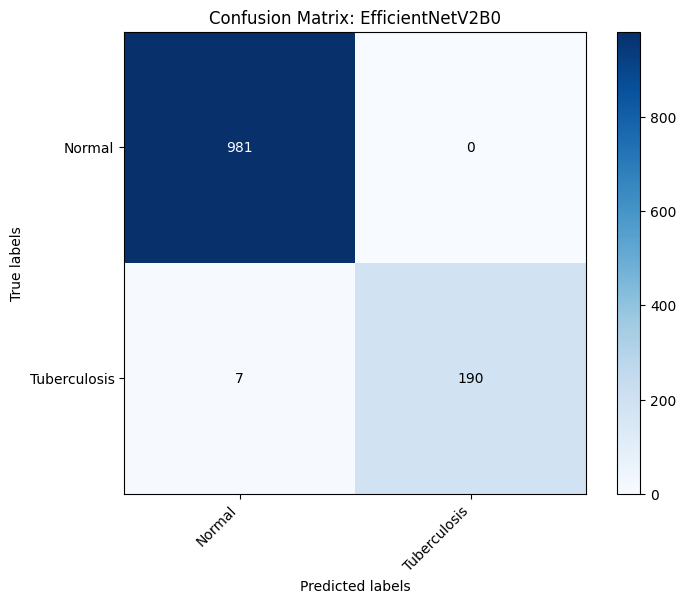

In [15]:
# Get class names from the dataset
class_names = test_ds.class_names

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the validation dataset and collect true and predicted labels
for images, labels in val_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(loaded_model.predict(images), axis=1))

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix: EfficientNetV2B0')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Label x-axis ticks with class names
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45, ha='right')

# Label y-axis ticks with class names
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)

# Determine text color based on background color of each cell
thresh = conf_matrix.max() / 2.0  # Threshold for determining text color
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text_color = 'white' if conf_matrix[i, j] > thresh else 'black'  # Use white text if cell value is above threshold
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color=text_color)

plt.show()

In [16]:
# Compute precision, recall, and F1 score for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

# Compute macro-averaged precision, recall, and F1 score
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print precision, recall, and F1 score for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1[i]:.4f}")
    print()

# Print macro-averaged precision, recall, and F1 score
print("Macro-Averaged Metrics:")
print(f"  Macro-Averaged Precision: {macro_precision:.4f}")
print(f"  Macro-Averaged Recall: {macro_recall:.4f}")
print(f"  Macro-Averaged F1 Score: {macro_f1:.4f}")

Class: Normal
  Precision: 0.9929
  Recall: 1.0000
  F1 Score: 0.9964

Class: Tuberculosis
  Precision: 1.0000
  Recall: 0.9645
  F1 Score: 0.9819

Macro-Averaged Metrics:
  Macro-Averaged Precision: 0.9965
  Macro-Averaged Recall: 0.9822
  Macro-Averaged F1 Score: 0.9892


#### MobileNetV3

In [17]:
# Define model without top layers
pretrained_model2 = keras.applications.MobileNetV3Large(include_top=False,
                                             input_shape=(224, 224, 3),
                                             weights='imagenet')

# Freeze the layers of the base model
for layer in pretrained_model2.layers:
    layer.trainable = False
    
#Define the Sequential model
model2 = keras.Sequential([
    pretrained_model2,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Adding L2 regularization
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Adding L2 regularization
    Dense(2, activation='softmax')
])

# Print model summary
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 47040)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               12042496  
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
Total params: 15055426 (57.43 MB)
Trainable params: 12059074 (46.00 MB)
Non-trainable params: 2996352 (11.43 MB)
_______

In [19]:
# Define a callback to save the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint('MobileNetV3_BestModel.h5')

# Compile the model with callbacks
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks to the fit method
history2 = model2.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_callback]  # Add both callbacks
)


Epoch 1/10
61/61 [==============================] - ETA: 0s - loss: 1.7082 - accuracy: 0.9739

C:\Users\alimm\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61/61 [==============================] - 88s 1s/step - loss: 1.7082 - accuracy: 0.9739 - val_loss: 1.0317 - val_accuracy: 0.9881
Epoch 2/10
61/61 [==============================] - 71s 1s/step - loss: 0.8641 - accuracy: 0.9850 - val_loss: 0.5956 - val_accuracy: 0.9924
Epoch 3/10
61/61 [==============================] - 70s 1s/step - loss: 0.4856 - accuracy: 0.9894 - val_loss: 0.3802 - val_accuracy: 0.9932
Epoch 4/10
61/61 [==============================] - 71s 1s/step - loss: 0.3914 - accuracy: 0.9889 - val_loss: 0.3269 - val_accuracy: 0.9881
Epoch 5/10
61/61 [==============================] - 71s 1s/step - loss: 0.3049 - accuracy: 0.9868 - val_loss: 0.2890 - val_accuracy: 0.9932
Epoch 6/10
61/61 [==============================] - 69s 1s/step - loss: 0.2469 - accuracy: 0.9948 - val_loss: 0.1895 - val_accuracy: 0.9975
Epoch 7/10
61/61 [==============================] - 71s 1s/step - loss: 0.2225 - accuracy: 0.9891 - val_loss: 0.2631 - val_accuracy: 0.9788
Epoch 8/10
61/61 [=============

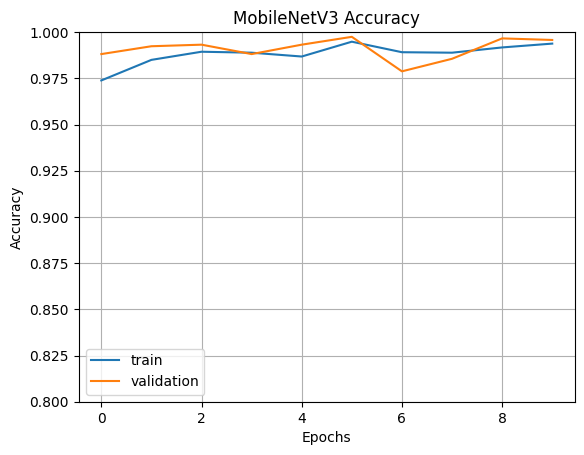

In [20]:
fig4 = plt.gcf()
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.axis(ymin=0.8,ymax=1)
plt.grid()
plt.title('MobileNetV3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [21]:
loaded_model2 = load_model('MobileNetV3_BestModel.h5')

1/1 [==============================] - 4s 4s/step


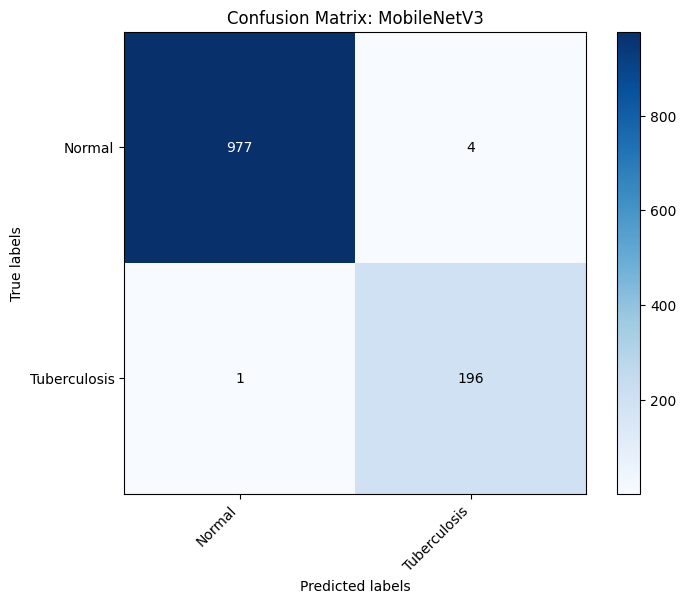

In [22]:
# Get class names from the dataset
class_names = test_ds.class_names

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the validation dataset and collect true and predicted labels
for images, labels in val_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(loaded_model2.predict(images), axis=1))

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix: MobileNetV3')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Label x-axis ticks with class names
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45, ha='right')

# Label y-axis ticks with class names
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)

# Determine text color based on background color of each cell
thresh = conf_matrix.max() / 2.0  # Threshold for determining text color
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text_color = 'white' if conf_matrix[i, j] > thresh else 'black'  # Use white text if cell value is above threshold
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color=text_color)

plt.show()

In [23]:
# Compute precision, recall, and F1 score for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

# Compute macro-averaged precision, recall, and F1 score
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print precision, recall, and F1 score for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1[i]:.4f}")
    print()

# Print macro-averaged precision, recall, and F1 score
print("Macro-Averaged Metrics:")
print(f"  Macro-Averaged Precision: {macro_precision:.4f}")
print(f"  Macro-Averaged Recall: {macro_recall:.4f}")
print(f"  Macro-Averaged F1 Score: {macro_f1:.4f}")

Class: Normal
  Precision: 0.9990
  Recall: 0.9959
  F1 Score: 0.9974

Class: Tuberculosis
  Precision: 0.9800
  Recall: 0.9949
  F1 Score: 0.9874

Macro-Averaged Metrics:
  Macro-Averaged Precision: 0.9895
  Macro-Averaged Recall: 0.9954
  Macro-Averaged F1 Score: 0.9924


#### NASNetMobile

In [24]:
# Define model without top layers
pretrained_model3 = keras.applications.NASNetMobile(include_top=False,
                                             input_shape=(224, 224, 3),
                                             weights='imagenet')

# Freeze the layers of the base model
for layer in pretrained_model3.layers:
    layer.trainable = False
    
#Define the Sequential model
model3 = keras.Sequential([
    pretrained_model3,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Adding L2 regularization
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Adding L2 regularization
    Dense(2, activation='softmax')
])

# Print model summary
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 flatten_3 (Flatten)         (None, 51744)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               13246720  
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 2)                 130       
                                                                 
Total params: 17533014 (66.88 MB)
Trainable params: 13263298 (50.60 MB)
Non-trainable params: 4269716 (16.29 MB)
_________________________________________________________________


In [25]:
# Define a callback to save the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint('NASNetMobile_BestModel.h5')

# Compile the model with callbacks
model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks to the fit method
history3 = model3.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_callback]  # Add both callbacks
)

Epoch 1/10
61/61 [==============================] - ETA: 0s - loss: 5.5982 - accuracy: 0.8465

C:\Users\alimm\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61/61 [==============================] - 180s 2s/step - loss: 5.5982 - accuracy: 0.8465 - val_loss: 3.5005 - val_accuracy: 0.8964
Epoch 2/10
61/61 [==============================] - 249s 4s/step - loss: 2.6447 - accuracy: 0.8931 - val_loss: 2.3173 - val_accuracy: 0.9032
Epoch 3/10
61/61 [==============================] - 109s 2s/step - loss: 1.5284 - accuracy: 0.9257 - val_loss: 1.1355 - val_accuracy: 0.9414
Epoch 4/10
61/61 [==============================] - 198s 3s/step - loss: 1.3060 - accuracy: 0.9179 - val_loss: 1.1401 - val_accuracy: 0.9406
Epoch 5/10
61/61 [==============================] - 90s 1s/step - loss: 1.3880 - accuracy: 0.9099 - val_loss: 1.0514 - val_accuracy: 0.9525
Epoch 6/10
61/61 [==============================] - 96s 2s/step - loss: 1.3215 - accuracy: 0.9208 - val_loss: 1.3146 - val_accuracy: 0.9261
Epoch 7/10
61/61 [==============================] - 100s 2s/step - loss: 1.4306 - accuracy: 0.9063 - val_loss: 1.2942 - val_accuracy: 0.9261
Epoch 8/10
61/61 [========

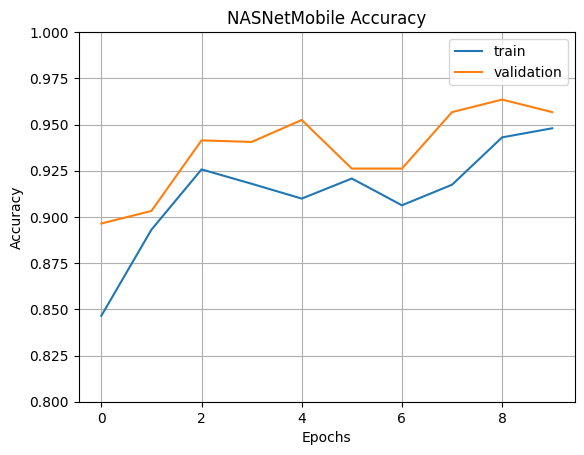

In [26]:
fig4 = plt.gcf()
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.axis(ymin=0.8,ymax=1)
plt.grid()
plt.title('NASNetMobile Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [27]:
loaded_model3 = load_model('NASNetMobile_BestModel.h5')

1/1 [==============================] - 5s 5s/step


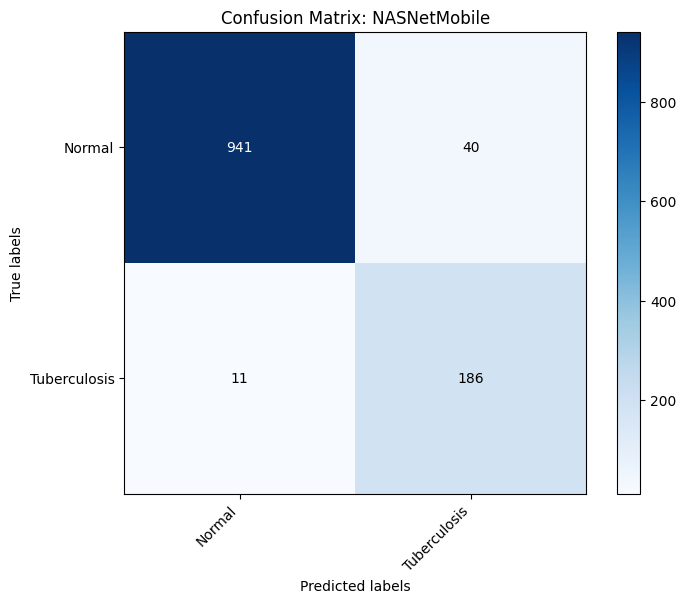

In [28]:
# Get class names from the dataset
class_names = test_ds.class_names

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the validation dataset and collect true and predicted labels
for images, labels in val_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(loaded_model3.predict(images), axis=1))

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix: NASNetMobile')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Label x-axis ticks with class names
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45, ha='right')

# Label y-axis ticks with class names
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)

# Determine text color based on background color of each cell
thresh = conf_matrix.max() / 2.0  # Threshold for determining text color
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text_color = 'white' if conf_matrix[i, j] > thresh else 'black'  # Use white text if cell value is above threshold
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color=text_color)

plt.show()

In [29]:
# Compute precision, recall, and F1 score for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

# Compute macro-averaged precision, recall, and F1 score
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print precision, recall, and F1 score for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1[i]:.4f}")
    print()

# Print macro-averaged precision, recall, and F1 score
print("Macro-Averaged Metrics:")
print(f"  Macro-Averaged Precision: {macro_precision:.4f}")
print(f"  Macro-Averaged Recall: {macro_recall:.4f}")
print(f"  Macro-Averaged F1 Score: {macro_f1:.4f}")

Class: Normal
  Precision: 0.9884
  Recall: 0.9592
  F1 Score: 0.9736

Class: Tuberculosis
  Precision: 0.8230
  Recall: 0.9442
  F1 Score: 0.8794

Macro-Averaged Metrics:
  Macro-Averaged Precision: 0.9057
  Macro-Averaged Recall: 0.9517
  Macro-Averaged F1 Score: 0.9265


#### DenseNet121

In [8]:
# Define model without top layers
pretrained_model4 = keras.applications.DenseNet121(include_top=False,
                                             input_shape=(224, 224, 3),
                                             weights='imagenet')

# Freeze the layers of the base model
for layer in pretrained_model4.layers:
    layer.trainable = False
    
#Define the Sequential model
model4 = keras.Sequential([
    pretrained_model4,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Adding L2 regularization
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Adding L2 regularization
    Dense(2, activation='softmax')
])

# Print model summary
model4.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 19899394 (75.91 MB)
Trainable params: 12861890 (49.06 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [9]:
# Define a callback to save the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint('DenseNet121_BestModel.h5')

# Compile the model with callbacks
model4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks to the fit method
history4 = model4.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_callback]  # Add both callbacks
)


Epoch 1/10


61/61 [==============================] - ETA: 0s - loss: 11.1463 - accuracy: 0.9050

C:\Users\alimm\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61/61 [==============================] - 285s 4s/step - loss: 11.1463 - accuracy: 0.9050 - val_loss: 4.0040 - val_accuracy: 0.9805
Epoch 2/10
61/61 [==============================] - 219s 4s/step - loss: 4.0307 - accuracy: 0.9645 - val_loss: 4.6435 - val_accuracy: 0.9499
Epoch 3/10
61/61 [==============================] - 226s 4s/step - loss: 5.6573 - accuracy: 0.9425 - val_loss: 2.9472 - val_accuracy: 0.9813
Epoch 4/10
61/61 [==============================] - 225s 4s/step - loss: 2.7050 - accuracy: 0.9832 - val_loss: 2.2174 - val_accuracy: 0.9864
Epoch 5/10
61/61 [==============================] - 224s 4s/step - loss: 2.1487 - accuracy: 0.9808 - val_loss: 2.0518 - val_accuracy: 0.9839
Epoch 6/10
61/61 [==============================] - 223s 4s/step - loss: 2.1837 - accuracy: 0.9707 - val_loss: 2.3353 - val_accuracy: 0.9593
Epoch 7/10
61/61 [==============================] - 224s 4s/step - loss: 1.8667 - accuracy: 0.9777 - val_loss: 1.4120 - val_accuracy: 0.9932
Epoch 8/10
61/61 [=====

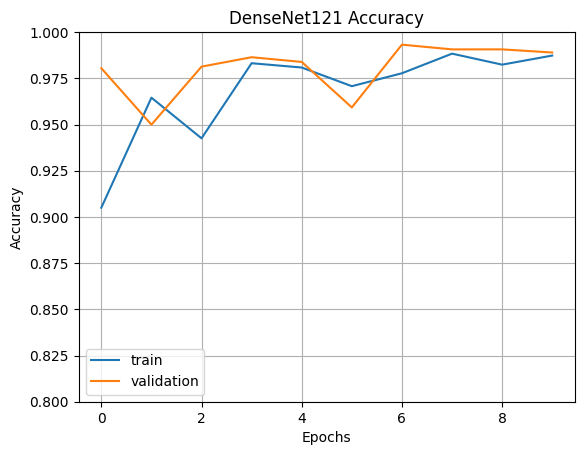

In [10]:
fig4 = plt.gcf()
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.axis(ymin=0.8,ymax=1)
plt.grid()
plt.title('DenseNet121 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [13]:
loaded_model4 = load_model('DenseNet121_BestModel.h5')

1/1 [==============================] - 3s 3s/step


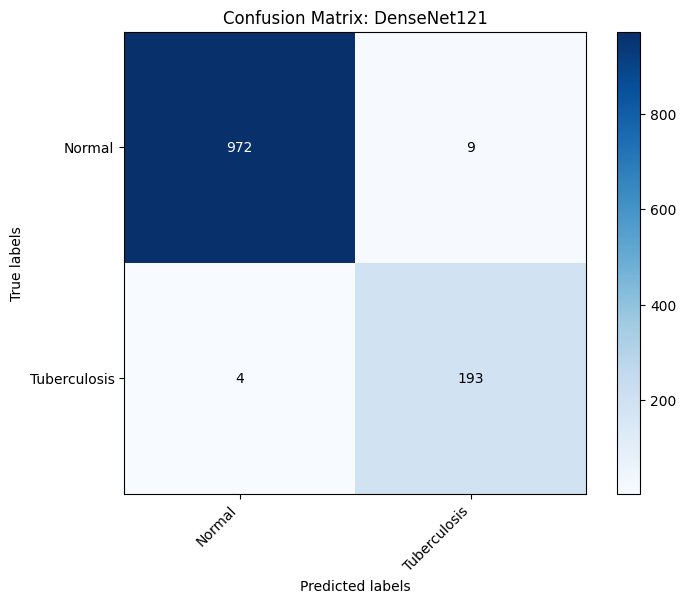

In [14]:
# Get class names from the dataset
class_names = test_ds.class_names

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the validation dataset and collect true and predicted labels
for images, labels in val_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(loaded_model4.predict(images), axis=1))

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix: DenseNet121')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Label x-axis ticks with class names
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45, ha='right')

# Label y-axis ticks with class names
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)

# Determine text color based on background color of each cell
thresh = conf_matrix.max() / 2.0  # Threshold for determining text color
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text_color = 'white' if conf_matrix[i, j] > thresh else 'black'  # Use white text if cell value is above threshold
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color=text_color)

plt.show()

In [15]:
# Compute precision, recall, and F1 score for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

# Compute macro-averaged precision, recall, and F1 score
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print precision, recall, and F1 score for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1[i]:.4f}")
    print()

# Print macro-averaged precision, recall, and F1 score
print("Macro-Averaged Metrics:")
print(f"  Macro-Averaged Precision: {macro_precision:.4f}")
print(f"  Macro-Averaged Recall: {macro_recall:.4f}")
print(f"  Macro-Averaged F1 Score: {macro_f1:.4f}")

Class: Normal
  Precision: 0.9959
  Recall: 0.9908
  F1 Score: 0.9934

Class: Tuberculosis
  Precision: 0.9554
  Recall: 0.9797
  F1 Score: 0.9674

Macro-Averaged Metrics:
  Macro-Averaged Precision: 0.9757
  Macro-Averaged Recall: 0.9853
  Macro-Averaged F1 Score: 0.9804
